In [72]:
import os, glob

ps = glob.glob('datasets/RESC/pseudo_label/*')


In [3]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import torch.nn as nn
import torch
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
model = resnet50(pretrained=True)
model=nn.DataParallel(model)
target_layer = [model.module.layer4[-1]]
input_tensor = torch.rand(2, 3, 224, 224)
targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
cam=GradCAM(model=model.module, target_layers=target_layer, use_cuda=True)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam.shape


(2, 224, 224)

: 

ours: DME-224974-1, DME-4240465-16
duke: subject_2_25, subject_5_8, subject_7_36
resc: sn8547_83 sn22697_94 sn29218_80 sn8547_89

In [106]:
from PIL import Image
import numpy as np
xx = np.array(Image.open('paper/anomaly/gt.png'))

In [109]:
xx[xx!=191] = 0
xx[xx==191]=255

In [111]:
import cv2
cv2.imwrite('paper/anomaly/gt_new.png', xx)

True

In [28]:
import numpy as np
resc_cls_res1 = np.load('cls_results/resc_cls_seam_1part.npy', allow_pickle=True).item()
resc_cls_res2 = np.load('cls_results/resc_cls_seam_2part.npy', allow_pickle=True).item()

In [32]:
x = np.concatenate([resc_cls_res1['pred'], resc_cls_res2['pred']])
y = np.concatenate([resc_cls_res1['gt'], resc_cls_res2['gt']])

In [33]:
x.shape, y.shape

((1920, 2), (1920, 2))

In [31]:
len(set(resc_cls_res1['name']+resc_cls_res2['name']))

1920

In [2]:
import numpy as np
our_cls_res = np.load('cls_results/ours_cls.npy', allow_pickle=True).item()

In [4]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, roc_auc_score
num_cls = ['SRF', 'IRF', 'EZ disrupted', 'HRD']#['SRF', 'PED']
def calculate_classification_infer(preds_list, gt_list):
    prob_predicted = np.array(preds_list)
    sparse_predicted = np.round(prob_predicted)
    gt = np.array(gt_list)

    f1m = f1_score(gt, sparse_predicted, average = 'macro')
    f1mi = f1_score(gt, sparse_predicted, average = 'micro')
    acc, class_acc = 0, [0]* len(num_cls)
    for i, pred in enumerate(sparse_predicted):
        acc +=  accuracy_score(gt[i],pred)
        class_acc += (gt[i]==pred) * 1
    class_acc = class_acc / len(sparse_predicted)
    res_dic = {'acc': acc / len(sparse_predicted), 'f1m': f1m, 'f1mi': f1mi}
    for i in range(len(num_cls)):
        res_dic[num_cls[i]] = class_acc[i]

    print(gt.sum(axis = 0), sparse_predicted.sum(axis = 0), gt.shape)
    # drop background class as they are all 1 then eroor roc
    roc_class = roc_auc_score(gt, prob_predicted, average=None)
    roc_avg = roc_auc_score(gt, prob_predicted, average='weighted')
    auc_dic = {'mean_auc:':roc_avg}
    for i in range(len(num_cls)):
        auc_dic[num_cls[i]] = roc_class[i]
    return res_dic, auc_dic
calculate_classification_infer(our_cls_res['pred'], our_cls_res['gt'])

[13. 90. 64. 41.] [17. 86. 11. 23.] (342, 4)


({'acc': 0.9305555555555556,
  'f1m': 0.6863068181818182,
  'f1mi': 0.7246376811594202,
  'SRF': 0.9883040935672515,
  'IRF': 0.9473684210526315,
  'EZ disrupted': 0.8450292397660819,
  'HRD': 0.9415204678362573},
 {'mean_auc:': 0.984625430938859,
  'SRF': 0.999298573766659,
  'IRF': 0.992283950617284,
  'EZ disrupted': 0.9654901079136691,
  'HRD': 0.9930313588850175})

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
sparse_predicted = np.round(our_cls_res['pred'])
cf = classification_report(our_cls_res['gt'], sparse_predicted)

/home/jiaqi/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/jiaqi/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [16]:
print(cf)

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       0.92      0.88      0.90        90
           2       1.00      0.17      0.29        64
           3       0.96      0.54      0.69        41

   micro avg       0.91      0.60      0.72       208
   macro avg       0.91      0.65      0.69       208
weighted avg       0.94      0.60      0.67       208
 samples avg       0.24      0.18      0.20       208



In [8]:
np.unique(our_cls_res['gt']), np.unique(our_cls_res['pred'])

(array([0., 1.]), array([6.59378145e-16, 1.05383240e-14, 1.88200218e-14, ...,
        9.99998450e-01, 9.99999523e-01, 1.00000000e+00]))

In [ ]:
resc_cls_res['pred'].flatten()

In [36]:
len([idx for idx, x in enumerate(resc_cls_res['pred'].flatten()) if x < 0.5])

101

In [2]:
# resc sn9291_59 for anomaly illustration
from PIL import Image
import numpy as np
orig_img = Image.open('datasets/RESC/valid/original_images/sn9291_59.bmp')
gt = Image.open('datasets/RESC/valid/label_images/sn9291_59.bmp')
resized_orig = orig_img.resize((739,741))
resized_gt = gt.resize((739,741))
resized_orig.save('paper/anomaly/orig.png')
resized_gt.save('paper/anomaly/gt.png')

### 2 lesions: resc sn8828_86.npy threds 0.96 recam 0.925 looks better for recam..### 1 lesion: resc sn8468_71.bmp threds 0.96 recam  / seam
### 1 lesion: duke subject_10_28 (datasets-2015_BOE_Chiu-segment_annotation-images-subject_10_28) 0.85 recam   / seam
### 1 lesion: ours  DME-224974-1

In [67]:
import numpy as np
from PIL import Image
img_name = 'sn8468_71'
test = np.load(f'outputs_inference/{img_name}.npy', allow_pickle=True).item()
orig_img = np.asarray(Image.open(f'datasets/RESC/valid/original_images/{img_name}.bmp'))
if len(orig_img.shape) == 3:
    orig_img = orig_img[...,0]
rgb_img = (orig_img / 255).copy()
if rgb_img.ndim == 2:
    rgb_img = np.repeat(rgb_img[..., np.newaxis], 3, -1)
seg = test['sem_cam']
gt = np.asarray(Image.open(f'datasets/RESC/valid/label_images/{img_name}.bmp'))

In [432]:
seam_duke_mask = np.asarray(Image.open(f'baseline_models/SEAM/duke/crf_out/datasets+2015_BOE_Chiu+segment_annotation+images+{img_name}.png'))
pred_labels = seam_duke_mask

In [70]:
seam_resc_mask = np.asarray(Image.open(f'{img_name}.png'))
pred_labels = seam_resc_mask

In [7]:
type_color = {
    0: [0, 0, 0],  # black
    4: [255, 0, 0],  # srf red
    2: [165, 235, 52],  # irf green
    5: [0, 0, 255],  # ez blue
    1: [52, 195, 235],  # hrd yellow
    3: [255, 165, 0],  # rpe orange
    6: [255, 0, 255],  # back ground pink
}

In [9]:
## OURS
import numpy as np
from PIL import Image
import cv2
img_name = 'DME-4240465-9'
orig_img = np.asarray(Image.open(f'datasets/our_dataset/original/test/{img_name}.jpeg'))
if len(orig_img.shape) == 3:
    orig_img = orig_img[...,0]
rgb_img = (orig_img / 255).copy()
if rgb_img.ndim == 2:
    rgb_img = np.repeat(rgb_img[..., np.newaxis], 3, -1)
gt = np.asarray(Image.open(f'datasets/our_dataset/annot_combine/{img_name}.png'))

gt[gt==51] = 2
gt[gt==102] = 1
gt[gt==153] = 4
gt[gt==204] = 3
gt[gt==255] = 0 # we dont include RPE for now

color_gt = np.zeros_like(rgb_img)
for i_cls in range(1, 5):
    mask = gt == i_cls
    color_gt[:, :,][
        mask
    ] = type_color[i_cls]
color_gt = cv2.cvtColor(color_gt.astype(np.uint8), cv2.COLOR_BGR2RGB)
dst = cv2.addWeighted((255*rgb_img).astype(np.uint8), 1, color_gt.astype(np.uint8), 0.7, 0)
cv2.imwrite(f'paper/failures/{img_name}/gt_overlay.png', dst)

True

In [59]:
color_mask =  np.asarray(Image.open('paper/supplementary/DME-4240465-16/pred.png'))
color_mask[np.all(color_mask == (255, 255, 0), axis=-1)] = (0,0,0)
color_mask = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2RGB)

dst = cv2.addWeighted((255*rgb_img).astype(np.uint8), 1, color_mask.astype(np.uint8), 0.7, 0)
cv2.imwrite('paper/supplementary/DME-4240465-16/pred_overlay.png', dst)

True

In [4]:
## DUKE
import numpy as np
from PIL import Image
import cv2
img_name = 'subject_7_36'
orig_img = np.asarray(Image.open(f'datasets/2015_BOE_Chiu/segment_annotation/images/{img_name}.png'))
if len(orig_img.shape) == 3:
    orig_img = orig_img[...,0]
rgb_img = (orig_img / 255).copy()
if rgb_img.ndim == 2:
    rgb_img = np.repeat(rgb_img[..., np.newaxis], 3, -1)
gt = np.asarray(Image.open(f'datasets/2015_BOE_Chiu/segment_annotation/labels/{img_name}.png'))

gt[gt==255] = 1 

color_gt = np.zeros_like(rgb_img)
for i_cls in range(1, 2):
    mask = gt == i_cls
    color_gt[:, :,][
        mask
    ] = type_color[i_cls]
color_gt = cv2.cvtColor(color_gt.astype(np.uint8), cv2.COLOR_BGR2RGB)
dst = cv2.addWeighted((255*rgb_img).astype(np.uint8), 1, color_gt.astype(np.uint8), 0.7, 0)
cv2.imwrite(f'paper/supplementary/{img_name}/gt_overlay.png', dst)

True

In [10]:
## RESC
type_color = {
    0: [0, 0, 0],  # black
    1: [52, 195, 235],  # srf red
    2: [235, 211, 52],  # irf green
}
import numpy as np
from PIL import Image
import cv2
img_name = 'sn21294_59'
orig_img = np.asarray(Image.open(f'datasets/RESC/valid/original_images/{img_name}.bmp'))
if len(orig_img.shape) == 3:
    orig_img = orig_img[...,0]
rgb_img = (orig_img / 255).copy()
if rgb_img.ndim == 2:
    rgb_img = np.repeat(rgb_img[..., np.newaxis], 3, -1)
gt = np.asarray(Image.open(f'datasets/RESC/valid/label_images/{img_name}.bmp'))

gt[gt==128] = 2
gt[gt==191] = 1
gt[gt==255] = 0

color_gt = np.zeros_like(rgb_img)
for i_cls in range(1, 3):
    mask = gt == i_cls
    color_gt[:, :,][
        mask
    ] = type_color[i_cls]
color_gt = cv2.cvtColor(color_gt.astype(np.uint8), cv2.COLOR_BGR2RGB)

dst = cv2.addWeighted((255*rgb_img).astype(np.uint8), 1, color_gt.astype(np.uint8), 0.7, 0)
cv2.imwrite(f'paper/refine-illu/gt_overlay.png', dst)

True

In [30]:
gt[gt==128]=2
gt[gt==191]=1
gt[gt==255]=0
# gt[gt==255]=1

In [31]:
bg = np.ones_like(seg[:1,]) * 0.96
bg.shape, seg.shape
final_cams = np.concatenate((bg, seg))
print(final_cams.shape)
pred_labels = np.argmax(final_cams, axis=0).astype(np.uint8)
np.unique(pred_labels)

(2, 1024, 512)


array([0, 1], dtype=uint8)

In [8]:
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
visualization = show_cam_on_image(
    rgb_img, seg[0], use_rgb=True
)

cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)

In [423]:
cv2.imwrite(f'paper/duke/{img_name}/seam/fluid.png', cam_image)

True

In [75]:
import cv2
color_mask = np.zeros_like(rgb_img)
for i_cls in range(1, 2):
    mask = pred_labels == i_cls
    color_mask[:, :,][
        mask
    ] = type_color[i_cls]
color_mask = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2RGB)

In [ ]:
color_gt = np.zeros_like(rgb_img)
for i_cls in range(1, 2):
    mask = gt == i_cls
    color_gt[:, :,][
        mask
    ] = type_color[i_cls]
color_gt = cv2.cvtColor(color_gt.astype(np.uint8), cv2.COLOR_BGR2RGB)

In [413]:
cv2.imwrite(f'paper/duke/{img_name}/gt.png', color_gt)

True

In [18]:
cv2.imwrite(f'paper/resc/{img_name}/recam/pseudo_mask.png', color_mask)

True

In [57]:
color_mask = np.array(Image.open('paper/duke/subject_10_28/seam/pseudo_mask.png'))
color_mask = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2RGB)
color_gt = np.array(Image.open('paper/duke/subject_10_28/gt.png'))
color_gt = cv2.cvtColor(color_gt.astype(np.uint8), cv2.COLOR_BGR2RGB)

rgb_img = np.array(Image.open('/ssd1/jiaqi/retinal_project/datasets/2015_BOE_Chiu/segment_annotation/images/subject_10_28.png'))
rgb_img = (rgb_img / 255).copy()
if rgb_img.ndim == 2:
    rgb_img = np.repeat(rgb_img[..., np.newaxis], 3, -1)
img_name = 'subject_10_28'

In [76]:
dst = cv2.addWeighted((255*rgb_img).astype(np.uint8), 1, color_mask.astype(np.uint8), 0.7, 0)
cv2.imwrite(f'paper/resc/{img_name}/seam/mask_overlay.png', dst)

True

In [ ]:
Image.fromarray(color_mask)

In [33]:
tests_names = glob.glob('datasets/RESC/valid/label_images/*')
tests_names = [x.split('/')[-1].split('.')[0] for x in tests_names]

In [16]:
import pandas as pd
import numpy as np
resc_l = np.load('datasets/RESC/resc_cls_labels.npy', allow_pickle=True).item()

In [29]:
# sn8547_86, _87 to show the iteration capture small region

10880

In [53]:
gt_img = np.asarray(Image.open('datasets/RESC/valid/label_images/sn8547_86.bmp'))


In [57]:
type_color = {
    0: [0, 0, 0],  # black
    191: [255, 0, 0],  # srf red
    128: [0, 255, 0],  # irf green
    # 3: [0, 0, 255],  # ez blue
    # 4: [255, 255, 0],  # hrd yellow
    # 5: [255, 165, 0],  # rpe orange
    # 6: [255, 0, 255],  # back ground pink
}
color_mask = np.repeat(np.zeros_like(gt_img)[...,np.newaxis], 3, -1)
for i_cls in [191, 128]:
    mask = gt_img == i_cls
    color_mask[:, :,][
        mask
    ] = type_color[i_cls]

In [59]:
color_mask =Image.fromarray(color_mask)


In [62]:
color_mask.save('corlo.jpg')

In [36]:
[n for n, x in resc_l.items() if x.sum()==2 and n in tests_names]

['sn9291_90',
 'sn8828_85',
 'sn8828_87',
 'sn8547_86',
 'sn9291_88',
 'sn8547_79',
 'sn8547_89',
 'sn9291_87',
 'sn9291_89',
 'sn8547_88',
 'sn8828_88',
 'sn8828_86',
 'sn8547_87']

In [7]:
from PIL import Image
import numpy as np
def convert_resc_labels(img):
    # 0 background,
    # 1 lesion(need turn to background),  1 -> 0
    # 0.74 SRF(need turn to 1),           0.74 -> 1
    # 0.51 PED(need turn to 2)            0.51 -> 2
    # back: 0, ped: 128, srf: 191, retinal: 255
    img[img == 255] = 0
    img[img == 191] = 1
    img[img == 128] = 2
    return img
count = 0
count_srf = 0
for img_p in ps:
    img = np.asarray(Image.open(img_p))
    if 1 in img:
        count_srf +=1
    if 2 in img:
        count+=1
    
    img_name = img_p.split('/')[-1].replace('.png', '.bmp')
    gt_img = np.asarray(Image.open('datasets/RESC/train/label_images/'+img_name))
    gt_img_norm = convert_resc_labels(gt_img)
    # print(img.shape, gt_img_norm.shape)
    if not np.array_equal(np.unique(img), np.unique(gt_img_norm)):
        print(np.unique(img), np.unique(gt_img_norm))
    if 1 in img and 2 in img:
        break
    

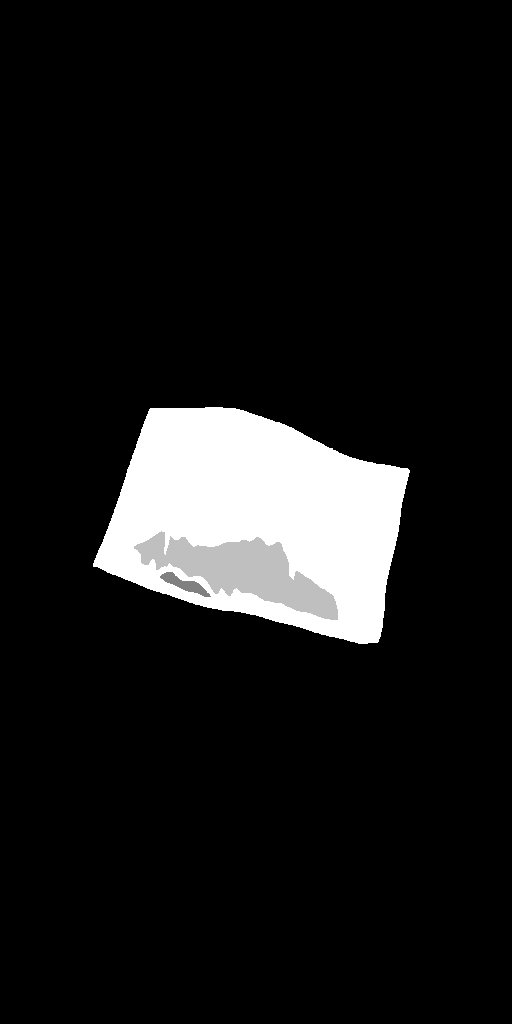

In [11]:
Image.open('datasets/RESC/train/label_images/'+img_name)

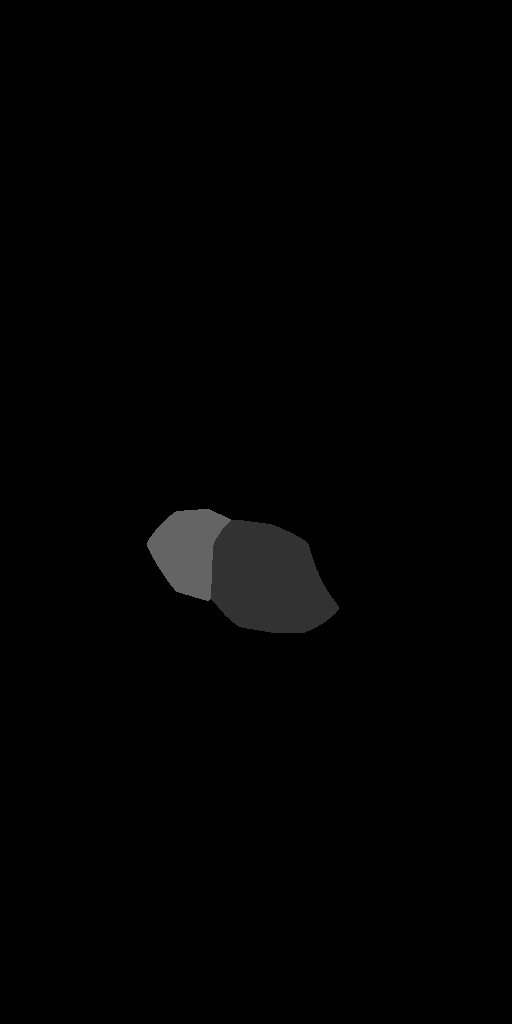

In [13]:
Image.fromarray(img*50)

In [6]:
count, count_srf

(402, 2934)

In [3]:
img_name

'sn9234_78.bmp'

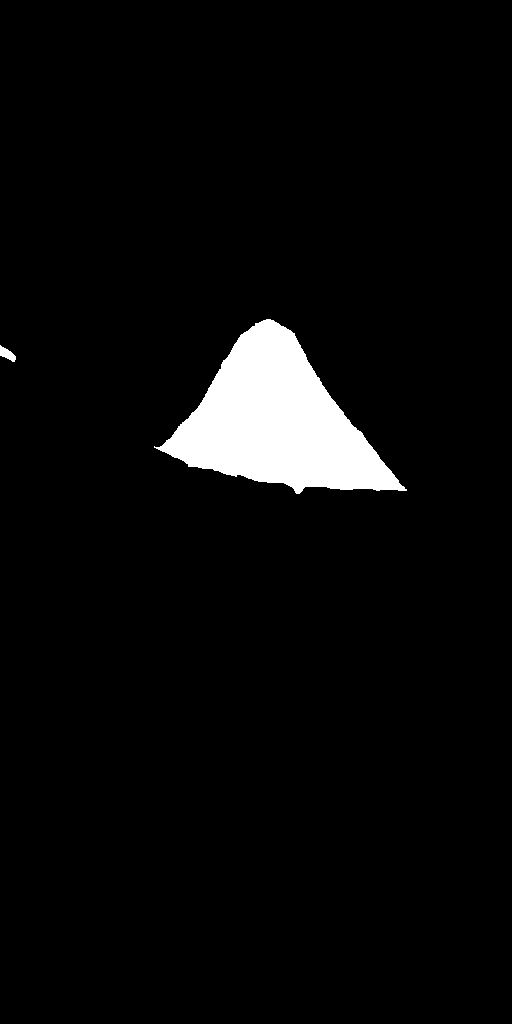

In [5]:
Image.fromarray(gt_img*100)

In [18]:
np.unique(gt_img)

array([0, 1], dtype=uint8)

---

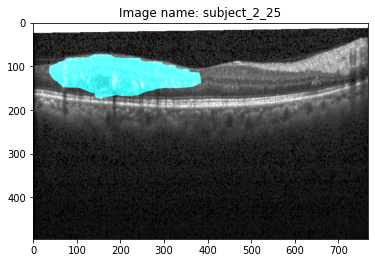

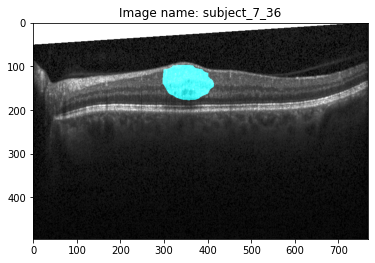

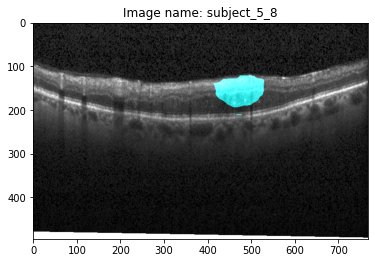

In [11]:
# datasets+2015_BOE_Chiu+segment_annotation+images+subject_1_10.png
# /ssd1/jiaqi/retinal_project/baseline_models/SEAM/duke/crf_out/datasets+2015_BOE_Chiu+segment_annotation+images+subject_1_10.png
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

imgs = ['subject_2_25', 'subject_7_36','subject_5_8']
duke_pth = "/ssd1/jiaqi/retinal_project/datasets/2015_BOE_Chiu/segment_annotation/images/"
for img in imgs:
    img_name = "datasets-2015_BOE_Chiu-segment_annotation-images-"+img
    test = Image.open(f"/ssd1/jiaqi/retinal_project/baseline_models/SEAM/duke/crf_out/datasets+2015_BOE_Chiu+segment_annotation+images+{img}.png")
    test = np.asarray(test)
    image = Image.fromarray(test.astype(np.float64)).convert('RGB')
    image = np.asarray(image)


    # cam_dict = np.load(f'/scr/xhu/jiaqi/baseline_models/irn/result_duke/sem_seg_valid/{img_name}.npy', allow_pickle=True).item()
    # '/scr/xhu/jiaqi/baseline_models/irn/result_ours/sem_seg_valid'
    # rw_up = cam_dict['sem_cam']
    # rw_up_bg = np.pad(rw_up, ((1, 0), (0, 0), (0, 0)), mode='constant', constant_values=thresh)
    # rw_pred = np.argmax(rw_up_bg, axis=0)
    # cls_labels = cam_dict['sem_keys'][rw_pred]
    # cls_labels[cls_labels == 255] = 0
    # image = Image.fromarray(cls_labels.astype(np.float64)).convert('RGB')
    # image = np.asarray(image)

    # label1 = get_annot_resc(img)
    label_img = np.copy(np.asarray(Image.open(duke_pth+img+'.png').convert('RGB')))
    # label_img[label_img == 255] = 1

    rgb_img = (label_img).copy()
    color_mask = np.zeros_like(rgb_img)

    color_mask[np.where((image==[1,1,1]).all(axis=2))] = [255,255,0]

    color_mask = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2RGB)

    dst = cv2.addWeighted(
        (rgb_img).astype(np.uint8), 1, color_mask.astype(np.uint8), 0.7, 0
    )
    plt.imshow(dst)
    # plt.axis('off')
    plt.title(f"Image name: {img}")
    # plt.tight_layout()
    plt.show()
    cv2.imwrite(f"/ssd1/jiaqi/retinal_project/paper/supplementary/seam_{img}.png", dst)

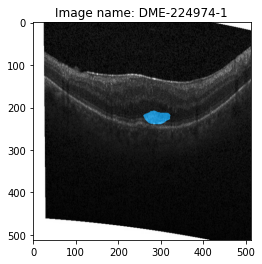

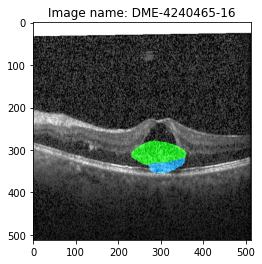

In [10]:
# /ssd1/jiaqi/retinal_project/baseline_models/SEAM/ours/crf_out
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

imgs = ['DME-224974-1', 'DME-4240465-16']
duke_pth = "/ssd1/jiaqi/retinal_project/datasets/our_dataset/original/test/" 
for img in imgs:
    test = Image.open(f"/ssd1/jiaqi/retinal_project/baseline_models/SEAM/ours/crf_out/{img}.png")
    test = np.asarray(test)
    image = Image.fromarray(test.astype(np.float64)).convert('RGB')
    image = np.asarray(image)
    img_name = img

    image = np.asarray(image)

    # label1 = get_annot_resc(img)
    label_img = np.copy(np.asarray(Image.open(duke_pth+img+'.jpeg').convert('RGB')))
    # label_img[label_img == 255] = 1

    rgb_img = (label_img).copy()
    color_mask = np.zeros_like(rgb_img)

    color_mask[np.where((image==[1,1,1]).all(axis=2))] = [255,0,0]
    color_mask[np.where((image==[2,2,2]).all(axis=2))] = [0,255,0]
    color_mask[np.where((image==[3,3,3]).all(axis=2))] = [255,165,0]
    # color_mask[np.where((image==[4,4,4]).all(axis=2))] = [255,255,0]
    # color_mask[np.where((image==[4,4,4]).all(axis=2))] = [0,0,0]

    color_mask = cv2.cvtColor(color_mask.astype(np.uint8), cv2.COLOR_BGR2RGB)

    dst = cv2.addWeighted(
        (rgb_img).astype(np.uint8), 1, color_mask.astype(np.uint8), 0.7, 0
    )
    plt.imshow(dst)
    # plt.axis('off')
    plt.title(f"Image name: {img}")
    # plt.tight_layout()
    plt.show()
    cv2.imwrite(f"/ssd1/jiaqi/retinal_project/paper/supplementary/seam_{img}.png", dst)

In [1]:
import os

In [2]:
len(os.listdir("/ssd1/jiaqi/retinal_project/datasets/2015_BOE_Chiu/segment_annotation/images"))

78